# 1. Imports

In [9]:
# !pip install adversarial-robustness-toolbox

In [25]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Initialization of constant values for the problem

In [4]:
input_names = ['rho','theta','psi','v_own','v_int']
ACAS_labels = ["COC","WR","WL","SR","SL"]

X_mean = np.array( [1.9791091*1e4, 0.0, 0.0, 650.0, 600.0] )
X_range = np.array( [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0] )
X_dom = np.array([ [0.0,    -pi, -pi, 100.0,     0.0],
                   [60760.0, pi,  pi, 1200.0, 1200.0] ])

print("> Domaine des inputs :")
inputs_domain = np.zeros((2,5))
inputs_domain[0,0] = (X_dom[0,0]-X_mean[0])/X_range[0]
inputs_domain[1,0] = (X_dom[1,0]-X_mean[0])/X_range[0]
print("- {0} : [{1},{2}]".format(input_names[1],inputs_domain[0,0],inputs_domain[1,0]))
for k in range(1,5):
    inputs_domain[0,k] = -0.5 ; inputs_domain[1,k] = 0.5
    print("- {0} : [{1},{2}]".format(input_names[k],inputs_domain[0,k],inputs_domain[1,k]))

> Domaine des inputs :
- theta : [-0.32842287715105956,0.6798577687061284]
- theta : [-0.5,0.5]
- psi : [-0.5,0.5]
- v_own : [-0.5,0.5]
- v_int : [-0.5,0.5]


# 2. Attack random points and build a confusion matrix

In [42]:
def full_nets_id():
    """ Get the id of the 45 neural networks as pairs of two integers as string. """
    nets_id = []
    for k in range(11,60):
        if k%10 != 0:
            nets_id.append( (k//10,k%10) )
    return(nets_id)

In [5]:
def create_random_pts(npts, boundaries=inputs_domain):
    """ Generate 'npts' random points in the domain defined by the 'boundaries'. """
    pts = np.random.rand(npts, 5)
    for f in range(0,5):
        pts[:,f] *= (boundaries[1][f] - boundaries[0][f])
        pts[:,f] += boundaries[0][f]
    return(pts)

In [6]:
def conf_matrix(pred0, pred1, n_classes=5):
    """ Creates the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [7]:
def norm_rows(cmat):
    """ Normalizes the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [8]:
def load_attack(method, acas_model, iter=20, epsilon=0.8, etap=0.95):
    """ Choose your attack with 'method'. """
    
    if method == "nf":
        return(NewtonFool(classifier = acas_model, 
                          eta = etap, 
                          max_iter = iter,
                          verbose = True))
    
    elif method == "fgsm":
        return(FastGradientMethod(estimator = acas_model,
                                  eps = epsilon))
    
    elif method == "cw":
        return(CarliniLInfMethod(classifier = acas_model,
                                 initial_const = 1.0, 
                                 max_iter = iter, 
                                 verbose = True))
    elif method == "Deepfool":
        return DeepFool(classifier=acas_model, max_iter=iter)
    
    else:
        raise Exception("'{0}' is not a valid attack.".format(method))

In [21]:
def build_confusion_matrix(N, method, num_net, folder="/content/", show=True, savefile=None, iter=20,
                                                                                             epsilon=0.001,
                                                                                             etap=0.95):
    """Do not forget to set folder and, if you use Colab, to import your neural networks!"""
    # 1 - Load the model ACAS
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))

    # 2 - Transform into art form
    
    ACAS_classifier = TensorFlowV2Classifier(model = model,
                                             loss_object = MSE,
                                             train_step = None,
                                             nb_classes = 5,
                                             input_shape = (1, 5),
                                             clip_values = (inputs_domain[0,:],inputs_domain[1,:]))

    attack = load_attack(method, ACAS_classifier, iter = iter,
                                                  epsilon = epsilon,
                                                  etap = etap)

    # 3 - Apply the attack on N random points
    
    base_pts = create_random_pts(N, boundaries=inputs_domain)
    adv_pts = attack.generate(base_pts)
    
    base_pred = model.predict(base_pts)
    base_advice = np.argmin(base_pred, axis=1)
    
    adv_pred = model.predict(adv_pts)
    adv_advice = np.argmin(adv_pred, axis=1)

    # 4 - Confusion matrix
    
    cmat = conf_matrix(base_advice, adv_advice)
    base_count = (np.bincount(np.concatenate((base_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
    adv_count = (np.bincount(np.concatenate((adv_advice,np.arange(0,5)))) - np.ones(5)).astype(int)
    
    # 5 - Show confusion matrix with normalized rows
    
    ncmat = norm_rows(cmat)    
    if show or (savefile!=None):
        index0 = [ACAS_labels[i] + " ({0})".format(base_count[i]) for i in range(5)]
        index1 = ["adv-" + ACAS_labels[i] + " ({0})".format(adv_count[i]) for i in range(5)]
        df_cmat = pd.DataFrame(ncmat, index = index0, columns = index1)

        plt.figure(figsize = (10,7))
        sns.heatmap(df_cmat, annot=True)
        plt.title("Confusion matrix - " + method.upper() + " - #{0}".format(N) + " - network {0}-{1}".format(num_net[0], num_net[1]))
        if show:
            plt.show()
        if savefile:
            plt.savefig(savefile)
    
    return(cmat, ncmat)

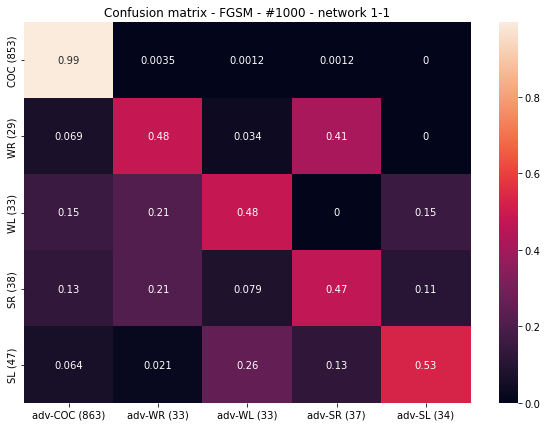

In [27]:
cmat, ncmat = build_confusion_matrix(1000, "fgsm", (1, 1), epsilon=0.001, folder="ACAS_XU_tf_keras/", show=True)

In [ ]:
# Example where we generate several cmat which are automatically saved
for eps in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]:
    filename = "fgsm_cmat/cmat_eps_" + str(eps) + ".png"
    _,_ = build_confusion_matrix(10000, "fgsm", (1, 1), epsilon=eps, folder="ACAS_XU_tf_keras/", savefile=filename, show=False)
    print(eps)

# 3. Plot the evolution of the matrix coefficients when a parameter changes

In [35]:
def cmat_tracking(N, method, num_net, folder="/content/", param_range=[0]):
    """ Plot the evolution of the coefficients of the cmat when we explore param_range. """
    
    # 1 - Load the model ACAS
    
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))

    # 2 - Transform into art form
    
    ACAS_classifier = TensorFlowV2Classifier(model = model,
                                             loss_object = MSE,
                                             train_step = None,
                                             nb_classes = 5,
                                             input_shape = (1, 5),
                                             clip_values = (inputs_domain[0,:],inputs_domain[1,:]))
    
    # 3 - Generate N random points and create the 3D matrix to store the cmat
    
    base_pts = create_random_pts(N, boundaries=inputs_domain)
    base_pred = model.predict(base_pts)
    base_advice = np.argmin(base_pred, axis=1)
    base_count = (np.bincount(np.concatenate((base_advice,np.arange(0,5)))) - np.ones(5)).astype(int)

    ncmat = len(param_range)
    confusion_cube = np.zeros((ncmat+1,5,5))
    confusion_cube[0] = np.eye(5)*base_count # base points without any attack

    # 4 - Iter over the param_range and attack the base_pts
    
    print("> Apply {0} on nnet {1}-{2} for {3} points and each of the {4} configurations of the parameters :"
          .format(method.upper(), num_net[0], num_net[1], N, len(param_range)))
    
    for k in tqdm(range(len(param_range))):
        pk = param_range[k]
        attack = load_attack(method, ACAS_classifier, iter = None, epsilon = pk, etap = None)
        
        adv_pts = attack.generate(base_pts)
        adv_pred = model.predict(adv_pts)
        adv_advice = np.argmin(adv_pred, axis=1)
        
        confusion_cube[k+1] = conf_matrix(base_advice, adv_advice) # store the confusion matrix in the confusion cube

    return(confusion_cube)

In [36]:
eps_range = [0.001*k for k in range(1,100)]
cube_cmat = cmat_tracking(1000, "fgsm", (1, 1), folder="ACAS_XU_tf_keras/", param_range=eps_range)
# np.save("data_TOM/" + "cubecmat_fgsm_0.001.npy", cube_cmat)

  0%|                                                                                           | 0/99 [00:00<?, ?it/s]

> Apply FGSM on nnet 1-1 for 1000 points and each of the 99 configurations of the parameters :


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:27<00:00,  1.14it/s]


In [102]:
def kk_plot(bloc, lab1, lab2, prange, net=(1,1), attname="FGSM", pname="epsilon", ratio=True, show=True, savefile=None):
    """ Plot the evolution of component (lab1,lab2) as a function of prange in the simulation cube.
        Actually, there are two kinds of kk-plot wheter lab1=lab2 or not :
        - lab1=lab2 : plot the nb or % of points that remain well predicted as lab1=lab2
        - lab1!=lab2 : plot the nb or % of points whose initial prediction was lab1 but changed for lab2 """
    
    if len(bloc.shape) == 4: # more than one network
        nnet = bloc.shape[0] ; ncmat = bloc.shape[1] ; npts = bloc[0,0,0,0]
    elif len(bloc.shape) == 3: # a single network
        nnet = 1 ; ncmat = bloc.shape[0] ; npts = bloc[0,0,0] ; net = [net]
        bloc = np.array([bloc]) # now bloc has shape (1,ncmat,5,5)
    else:
        raise Exception("Invalid shape : 'bloc' has shape {0} but shape of size 3 or 4 is expected".format(bloc.shape))

    if len(prange) < ncmat: # need to consider the initial setting without any attack
        prange = [0] + prange
    
    ACAS_lab1 = ACAS_labels[lab1] ; ACAS_lab2 = ACAS_labels[lab2]
    
    fig = plt.figure(figsize=(8, 6))
    for num_net in range(nnet):
        
        tracked_coef = bloc[num_net,:,lab1,lab2]
        norm_coeff = bloc[num_net,0,lab1,lab1]
        (a,b) = net[num_net]

        if ratio: # plot a % of the total number of points in lab1 without any attack
            plt.plot(prange, tracked_coef/norm_coeff, label="{0}-{1}".format(a,b))
            plt.ylabel("points proportion in %", size=12)
        else: # plot the real number of points
            plt.plot(prange, tracked_coef, label="{0}-{1}".format(a,b))
            plt.ylabel("number of points", size=12)
        plt.xlabel(pname, size=12)
    
    if nnet == 1:
        plt.title("NNET {0}-{1} - Evolution from {2} to {3} with {4}".format(net[0][0],net[0][1],ACAS_lab1,ACAS_lab2,attname), size=15)
    else:
        plt.title("Evolution from {0} to {1} with {2}".format(ACAS_lab1,ACAS_lab2,attname), size=15)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if show and (savefile == None):
        plt.show()
    if savefile != None:
        plt.savefig(savefile) ; plt.close(fig)
        print("Plot {0}->{1} saved in {2}".format(ACAS_lab1, ACAS_lab2, savefile))

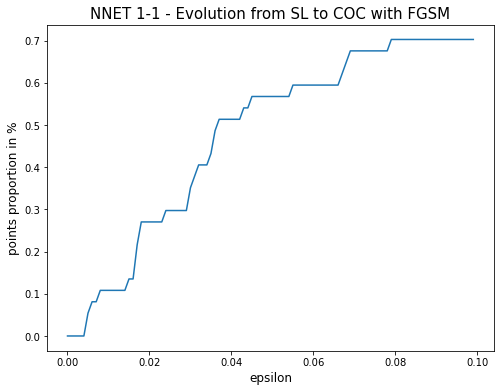

In [103]:
# simple kk-plot
kk_plot(cube_cmat, 4, 0, eps_range)

In [ ]:
# save automatically many kk-plot
for i in range(5):
    for j in range(5):
        kk_plot(cube_cmat, i, j, eps_range, savefile="data_TOM/" + "kk_plot_{0}-{1}".format(i,j))

# 4 - Analyse the different behaviours between the classes of networks

In [43]:
ID2num = full_nets_id()

nets_ID = [23,41,14,31,9,18,6,0,8] # one network in each of the 9 identified classes

nets_num = [ID2num[u] for u in nets_ID]
print("Selected networks (one in each class) : ", nets_num)

Selected networks (one in each class) :  [(3, 6), (5, 6), (2, 6), (4, 5), (2, 1), (3, 1), (1, 7), (1, 1), (1, 9)]


Plot evolution from COC to COC with FGSM

In [197]:
eps_range = [0.01*k for k in range(1,100)]

In [194]:
# generate a confusion cube for each of the 9 selected networks
for (a,b) in nets_num:
    cube_cmat = cmat_tracking(1000, "fgsm", (a, b), folder="ACAS_XU_tf_keras/", param_range=eps_range_01)
    np.save("data_TOM/" + "cubecmat_{0}-{1}_fgsm_0.001.npy".format(a,b), cube_cmat)
    print(a,b)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
3 6
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
5 6
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
2 6
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
4 5
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
2 1
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
3 1
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
1 7
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
1 1
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
1 9


In [52]:
# load the confusion cubes generated for the 9 selected networks
all_cube_cmat = np.zeros((9,len(eps_range)+1,5,5))
for k in range(9):
    (a,b) = nets_num[k]
    all_cube_cmat[k] = np.load("data_TOM/cube_cmat_fgsm_step0.01/" + "cubecmat_{0}-{1}_fgsm_0.01.npy".format(a,b))

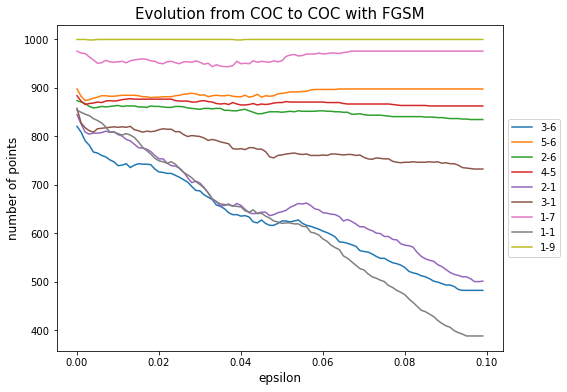

In [112]:
kk_multiplot(all_cube_cmat, 0, 0, eps_range, net=nets_num, ratio=False)